In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from keras.applications import VGG16
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
pwd

'/content'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
from google.colab import drive
ROOT = '/content/drive'
drive.mount(ROOT)

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/cpe_proj/COVID-Classifier/dataset/

/content/drive/MyDrive/cpe_proj/COVID-Classifier/dataset


In [ ]:
ls

original_images/  original_images_preprocessed/


# Loading and splitting data into two sets for training and test (80-20%)




In [ ]:
batch_size = 32 # the Size of the batches of data. Default: 32
IMG_W, IMG_H = 224, 224

In [ ]:
TRAIN_ds = tf.keras.preprocessing.image_dataset_from_directory(
            "original_images",
            labels="inferred",
            label_mode="categorical",
            class_names=None, # Only valid if "labels" is "inferred"
            # color_mode="rgb",
            batch_size=batch_size,
            image_size=(IMG_W, IMG_H),
            shuffle=True,
            seed=1337,
            validation_split=0.2,
            subset="training",
            follow_links=False,
            )
TEST_ds = tf.keras.preprocessing.image_dataset_from_directory(
            "original_images",
            labels="inferred",
            label_mode="categorical",
            class_names=None, # Only valid if "labels" is "inferred"
            # color_mode="rgb",
            batch_size=batch_size,
            image_size=(IMG_W, IMG_H),
            shuffle=True,
            seed=1337,
            validation_split=0.2,
            subset="validation",
            follow_links=False,
            )

Found 380 files belonging to 3 classes.
Using 304 files for training.
Found 380 files belonging to 3 classes.
Using 76 files for validation.


In [ ]:
for image_batch, labels_batch in TRAIN_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 3)


In [ ]:
type(TRAIN_ds)


tensorflow.python.data.ops.dataset_ops.BatchDataset

# using VGG16 convolutional layers as feature extractor:
## the VGG16 here is pre-trained by IMAGENET dataset

In [ ]:
#Instantiate convolutional base VGG16 for feature extraction

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_W, IMG_H, 3)) #include_top=False : to exclude the fully connected layers of the CNN

#Show Architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# importing higher-level copy and write functions as well as ImageDataGenerator
import os, shutil
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Defining function for feature extraction and label creation

datagen = ImageDataGenerator(rescale=1./255)

def extract_features(dataSET, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count,3)) # 3 is the number of labels in our dataset
    
    # Passing data through convolutional-base layers
    i = 0
    for inputs_batch, labels_batch in dataSET:
        features_batch = conv_base.predict(inputs_batch) # predict function gives the features (it uses conv_base the output of VGG code from the 2-last code section)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels


In [ ]:
#Calling the feature extraction function on the train and test datasets
#For running the model, train_features would be X_train and train_labels would be y_train

train_features, train_labels = extract_features(TRAIN_ds,304) # Total no. of files in train folder
test_features, test_labels = extract_features(TEST_ds,76)

In [ ]:
train_labels.shape, train_features.shape

((304, 3), (304, 7, 7, 512))

In [ ]:
test_labels.shape, test_features.shape

((76, 3), (76, 7, 7, 512))

In [ ]:
#train_features[0].shape
train_labels.shape

(304, 3)

In [ ]:
# reshaping data as features x and their corresponding lables y for SVM
x_train = (train_features.reshape(train_features.shape[0],-1))
y_train = (np.argmax(train_labels, axis=1, out=None))

# testing data
x_test = (test_features.reshape(test_features.shape[0],-1))
y_test = (np.argmax(test_labels, axis=1, out=None))

In [ ]:
x_train.shape, y_train.shape,  x_test.shape, y_test.shape

((304, 25088), (304,), (76, 25088), (76,))

## 304 componets with 25088 features => the curse of dimensionality 
addressed by Principal Component Analysis (PCA)

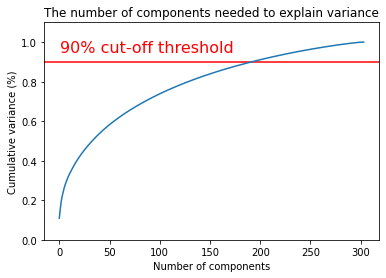

In [ ]:
# dimension reduction using PCA analysis

from sklearn.decomposition import PCA
fig, ax = plt.subplots()

plt.ylim(0.0,1.1)

plt.title('The number of components needed to explain variance')

plt.axhline(y=0.9, color='r', linestyle='-')
plt.text(0.5, 0.95, '90% cut-off threshold', color = 'red', fontsize=16)

pca_chk = PCA() #
pca_chk.fit(x_train)
plt.plot(np.cumsum(pca_chk.explained_variance_ratio_))

plt.xlabel("Number of components")
plt.ylabel("Cumulative variance (%)")
plt.title('The number of components needed to explain variance')

plt.show()

the above result shows 200 components are able to represent 90 percent of features

In [ ]:
# do NOT run this:
# another version of dimension reduction which takes a sheer amount of time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

print(__doc__)

pipe = Pipeline([
    # the reduce_dim stage is populated by the param_grid
    ('reduce_dim', 'passthrough'),
    ('classify', LinearSVC(dual=False, max_iter=10000))
])

N_FEATURES_OPTIONS = [100, 200]
C_OPTIONS = [1, 10]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]
reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid)

grid.fit(x_train, y_train)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')

plt.show()

# appying the *PCA*

In [ ]:
# dimension reduction using PCA analysis (cont'd)
n_pca_components=200
pca = PCA(n_components=n_pca_components)
train_pca = pca.fit_transform(x_train)
test_pca = pca.transform(x_test)
# train_pca = pca.transform(x_train)
# x_te = pca.transform(x_test)

# SVM for classification after appying the PCA

In [ ]:

# a grid search is performed on a set of parameters and kernels to select the best classifier

from sklearn import svm
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [1, 10, 100], 'kernel': ['linear']},
  {'C': [1, 10, 100], 'gamma': [0.001, 0.0001] , 'degree': [1,2,3], 'kernel': ['poly']},
 ]

# C dentos the regularization parameter  and gamma denotes  th Kernel coeff.
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid, refit=True)
clf.fit(pca.transform(x_train), y_train) # pca.transform(x_train) transforms data into the principal components


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100], 'kernel': ['linear']},
                         {'C': [1, 10, 100], 'degree': [1, 2, 3],
                          'gamma': [0.001, 0.0001], 'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
clf.cv_results_

{'mean_fit_time': array([0.00910587, 0.00900807, 0.00786819, 0.00791092, 0.00747228,
        0.02054524, 0.02048044, 0.02089744, 0.02111902, 0.0074132 ,
        0.00743427, 0.02046509, 0.02143264, 0.0214283 , 0.02096939,
        0.00746512, 0.0074554 , 0.02059984, 0.020608  , 0.02080526,
        0.02095528]),
 'mean_score_time': array([0.00239468, 0.00243325, 0.00200706, 0.00213943, 0.00195723,
        0.00356517, 0.0036088 , 0.00363836, 0.00364885, 0.00191774,
        0.001929  , 0.00358272, 0.00361567, 0.00363331, 0.00363359,
        0.0019381 , 0.0019423 , 0.00358276, 0.0036057 , 0.00366545,
        0.00367169]),
 'mean_test_score': array([0.95715847, 0.95715847, 0.95715847, 0.95715847, 0.95715847,
        0.90453552, 0.90453552, 0.79923497, 0.79923497, 0.95715847,
        0.95715847, 0.90453552, 0.90453552, 0.79923497, 0.79923497,
        0.95715847, 0.95715847, 0.90453552, 0.90453552, 0.79923497,
        0.79923497]),
 'param_C': masked_array(data=[1, 10, 100, 1, 1, 1, 1, 1, 1, 10

In [ ]:
clf.best_estimator_

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

the best estimator is a linear kernel with tuning parameter C = 1

The smaller the value of C, the more sensitive the algorithm is to the training data (higher variance and lower bias).

The larger the value of C, the less sensitive the algorithm is to the training data (lower variance and higher bias).

Ref. https://machinelearningmastery.com/support-vector-machines-for-machine-learning/

In [ ]:
y_pred_train = clf.predict(pca.transform(x_train))
y_pred_test = clf.predict(pca.transform(x_test))
y_pred_test.shape

(76,)

Accuracy on training set =  1.0


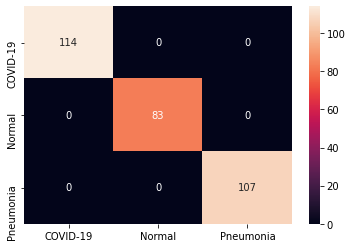

In [ ]:
# Print overall accuracy of TRAIN
# from sklearn.metrics import accuracy_score

from sklearn import metrics
print ("Accuracy on training set = ", metrics.accuracy_score(y_train, y_pred_train))

# Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

fig100 = plt.figure()
# fig100 = plt.figure(figsize=(10,10))
categories = ['COVID-19','Normal','Pneumonia']
cm = confusion_matrix(y_train, y_pred_train)
#print(cm)
sns.heatmap(cm, xticklabels =categories , yticklabels =categories, annot=True, fmt='d')

Accuracy on testing set =  1.0


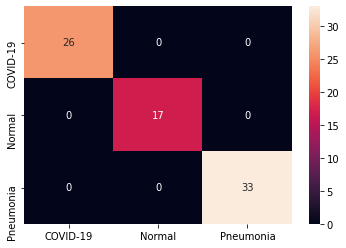

In [ ]:
# Print overall accuracy of TEST

print ("Accuracy on testing set = ", metrics.accuracy_score(y_test, y_pred_test))

# Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

fig100 = plt.figure()
categories = ['COVID-19','Normal','Pneumonia']
cm = confusion_matrix(y_test, y_pred_test)
#print(cm)
sns.heatmap(cm, xticklabels =categories , yticklabels =categories, annot=True)


# PCA and fully-connected NN layers for classification

two FC layers, 256 and 3 neurons


In [ ]:
#Add hidden dense layers and final output/classifier layer .
model = Sequential()
inputs = Input(shape=(n_pca_components,)) #Shape = n_components
hidden = Dense(256, activation='relu')(inputs)
#hidden1 = Dense(512, activation='relu')(inputs)
#hidden2 = Dense(256, activation='relu')(hidden1)
output = Dense(3, activation='relu')(hidden)
model = Model(inputs=inputs, outputs=output)

print(model.summary())
#
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

#Fit the model. Do not forget to use categorial Y values. 
hist = model.fit(train_pca, train_labels, epochs=20, verbose=1, validation_data=(test_pca, test_labels))

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
dense_34 (Dense)             (None, 256)               51456     
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 771       
Total params: 52,227
Trainable params: 52,227
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
10/10 [==============================] - 0s 11ms/step - loss: 5.8593 - categorical_accuracy: 0.4375 - val_loss: 4.2782 - val_categorical_accuracy: 0.5395
Epoch 2/20
10/10 [==============================] - 0s 4ms/step - loss: 4.4690 - categorical_accuracy: 0.5592 - val_loss: 3.5438 - val_categorical_accuracy: 0.6316
Epoch 3/20
10/10 [===========================

In [ ]:
##Predict on test dataset
predict_test = model.predict(test_pca)
predict_test = np.argmax(predict_test, axis=1)
# predict_test = le.inverse_transform(predict_test)
#

Accuracy on training set =  0.7105263157894737


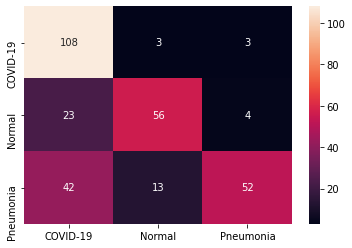

In [ ]:
from sklearn import metrics
print ("Accuracy on training set = ", metrics.accuracy_score(y_train, predict_train))

# Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

predict_train = model.predict(pca.transform(x_train))
predict_train = np.argmax(predict_train, axis=1)
fig100 = plt.figure()
categories = ['COVID-19','Normal','Pneumonia']
cm = confusion_matrix(y_train, predict_train)
#print(cm)
sns.heatmap(cm, xticklabels =categories , yticklabels =categories, annot=True, fmt='d')

Accuracy on testing set =  0.7236842105263158


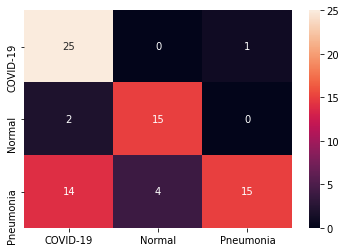

In [ ]:

print ("Accuracy on testing set = ", metrics.accuracy_score(y_test, predict_test))

# Confusion Matrix - verify accuracy of each class

fig100 = plt.figure()
categories = ['COVID-19','Normal','Pneumonia']
cm = confusion_matrix(y_test, predict_test)
#print(cm)
sns.heatmap(cm, xticklabels =categories , yticklabels =categories, annot=True)

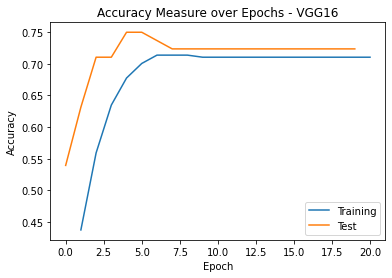

In [ ]:
epochs = [i for i in range(1,21)]
plt.plot(epochs, hist.history['categorical_accuracy'], hist.history['val_categorical_accuracy'])
plt.legend(['Training', 'Test'])
plt.title('Accuracy Measure over Epochs - VGG16')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

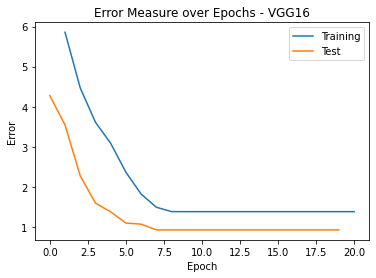

In [ ]:
plt.plot(epochs, hist.history['loss'], hist.history['val_loss'])
plt.legend(['Training', 'Test'])
plt.title('Error Measure over Epochs - VGG16')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

# the same procedures can be applied to VGG19 or other CNN arcituectures


In [ ]:
# train_features, train_labels

x_train_features = train_features.reshape(train_features.shape[0],-1)

In [ ]:
from keras.applications import VGG19
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_W, IMG_H, 3))

vgg19_base.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________